In [1]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import pickle
from sklearn.tree import DecisionTreeRegressor

import joblib


#forecaster = gas_forecaster.ModelForecaster

with open('train_y_df.pkl', 'rb') as f:
    train_y_df = pickle.load (f)
with open('train_df.pkl', 'rb') as f:
    train_df = pickle.load (f)
with open('test_y_df.pkl', 'rb') as f:
    test_y_df = pickle.load (f)
with open('test_df.pkl', 'rb') as f:
    test_df = pickle.load (f)


#unskalierte Werte
with open('unscaled_train_y_df.pkl', 'rb') as f:
    unscaled_train_y_df = pickle.load (f)
with open('unscaled_train_final_df.pkl', 'rb') as f:
    unscaled_train_final_df = pickle.load (f)
with open('unscaled_test_y.pkl', 'rb') as f:
    unscaled_test_y_df = pickle.load (f)
with open('unscaled_test_final_df.pkl', 'rb') as f:
    unscaled_test_final_df = pickle.load (f)
with open('diff_info.pkl', 'rb') as f:
    diff_info = pickle.load(f)

"""train_diff_order = diff_info['train_diff_order']
train_y_diff_order = diff_info['train_y_diff_order']
train_startwerte = diff_info['train_startwerte']
train_y_startwert = diff_info['train_y_startwert']"""

min_max_scaler = joblib.load('min_max_scaler.pkl')
y_min_max_scaler = joblib.load('y_min_max_scaler.pkl')

X = train_df
y = train_y_df



## SFS (Test)

Starte Feature Selection mit SFS...
SFS abgeschlossen.
 1 Features: MAE = 0.04086
 2 Features: MAE = 0.04091
 3 Features: MAE = 0.03944
 4 Features: MAE = 0.03855
 5 Features: MAE = 0.03677
 6 Features: MAE = 0.03651
 7 Features: MAE = 0.03573
 8 Features: MAE = 0.03573
 9 Features: MAE = 0.03618
10 Features: MAE = 0.03528
11 Features: MAE = 0.03538
12 Features: MAE = 0.03550
13 Features: MAE = 0.03544
14 Features: MAE = 0.03553
15 Features: MAE = 0.03529
16 Features: MAE = 0.03501
17 Features: MAE = 0.03508
18 Features: MAE = 0.03539
19 Features: MAE = 0.03589
20 Features: MAE = 0.03614
21 Features: MAE = 0.03578
22 Features: MAE = 0.03583
23 Features: MAE = 0.03589
24 Features: MAE = 0.03631
25 Features: MAE = 0.03623


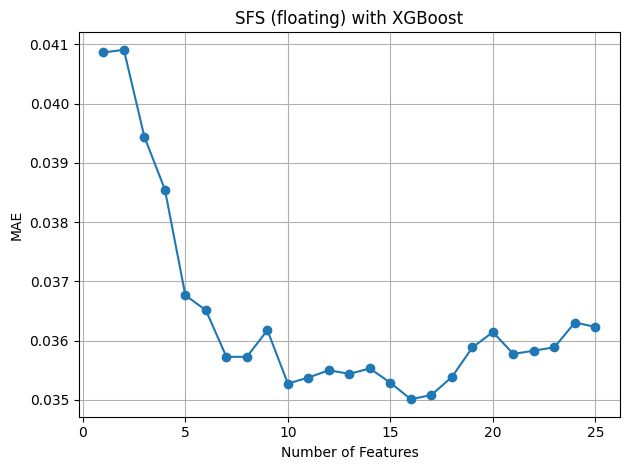


Beste Featureanzahl: 16
Beste Features: ['A-Flow Continental LNG Sendout ', 'S-Gas DA D', 'S-Power price_lag1', 'S-Gas DA D_lag1', 'S-Gas DA D_rollmean_3', 'S-Oil Spot Price (Brent)_rollmean_7', 'K-Wind speed_rollmin_7', 'K-Temperatur 2m_lag7', 'K-Temperatur 2m_rollmax_7', 'A-Flow Continental LNG Sendout _lag1', 'A-Flow Continental LNG Sendout _rollmin_7', 'P-EXY Average _lag1', 'N-Demand non-LDZ_lag1', 'N-Demand LDZ_lag7', 'Season_Summer', 'Season_Winter']


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from xgboost import XGBRegressor
# --- 1. Setup ---
X = train_df
y = train_y_df.values.ravel()

# XGBoost Modell
model = XGBRegressor(
    objective='reg:squarederror',  # Standard für Regressionsaufgaben
    max_depth=5,                   # wie beim Decision Tree
    learning_rate=0.1,             # Standardwert
    n_estimators=100,              # Anzahl Bäume
    random_state=42
)

# --- 2. TimeSeriesSplit ---
tscv = TimeSeriesSplit(n_splits=3)

# --- 3. SFS mit floating + erweitertem Featurebereich ---
sfs = SFS(
    estimator=model,
    k_features=(5, 25),
    forward=True,
    floating=True,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1
)
print("Starte Feature Selection mit SFS...")
sfs.fit(X, y)
print("SFS abgeschlossen.")
# --- 4. MAE vs Featureanzahl ---
metric_dict = sfs.get_metric_dict()
num_features = sorted(metric_dict.keys())
maes = [-metric_dict[k]['avg_score'] for k in num_features]

for k, mae in zip(num_features, maes):
    print(f"{k:2d} Features: MAE = {mae:.5f}")

plt.plot(num_features, maes, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('MAE')
plt.title('SFS (floating) with XGBoost')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 5. Beste Auswahl ---
best_k = num_features[np.argmin(maes)]
best_features = list(sfs.subsets_[best_k]['feature_names'])
print(f"\nBeste Featureanzahl: {best_k}")
print("Beste Features:", best_features)


## RFECV (genutzt mit 12 Features!)

Beste Anzahl an Features: 1
Ausgewählte Features: ['S-Gas DA D']


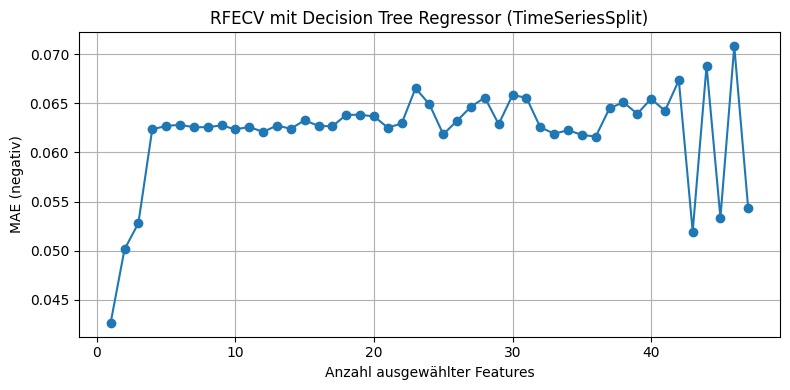

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Setup ---
X = train_df
y = train_y_df.values.ravel()

# --- 2. Modell ---
model = DecisionTreeRegressor(max_depth=4, random_state=42)

# --- 3. Zeitreihen-CV ---
cv = TimeSeriesSplit(n_splits=5)

# --- 4. RFECV mit TimeSeriesSplit ---
rfecv = RFECV(
    estimator=model,
    step=2,
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=-1
)
rfecv.fit(X, y)

# --- 5. Ergebnis ---
print("Beste Anzahl an Features:", rfecv.n_features_)
selected_features = X.columns[rfecv.support_].tolist()
print("Ausgewählte Features:", selected_features)



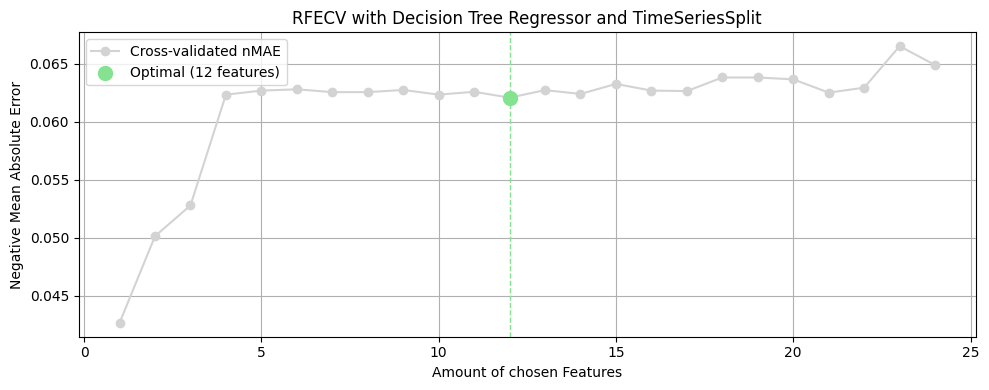

In [25]:

# --- Vorbereitung ---
max_display = 24
highlight = 12  # gewünschter Optimalpunkt
scores = -np.array(rfecv.cv_results_['mean_test_score'][:max_display])

# --- Plot ---
plt.figure(figsize=(10, 4))
plt.plot(range(1, max_display + 1), scores, marker='o', color='#D3D3D3', label='Cross-validated nMAE')

# Punkt bei 12 Features hervorheben

plt.scatter(highlight, scores[highlight - 1], color='#84E291', s=100, zorder=5, label='Optimal (12 features)')
plt.axvline(highlight, linestyle='--', color='#84E291', linewidth=1)

# --- Beschriftung ---
plt.xlabel('Amount of chosen Features')
plt.ylabel('Negative Mean Absolute Error')
plt.title('RFECV with Decision Tree Regressor and TimeSeriesSplit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
from collections import defaultdict
import numpy as np

# --- Feature-Ränge und Sortierung nach RFE-Rang ---
feature_ranks = list(zip(X.columns, rfecv.ranking_))
sorted_features = [name for name, rank in sorted(feature_ranks, key=lambda x: x[1])]

# --- MAE-Scores aus RFECV ---
scores = -np.array(rfecv.cv_results_['mean_test_score'])  # in positive MAE umwandeln
subset_sizes = range(1, len(scores) + 1)

# --- Subsets generieren ---
subsets_dict = defaultdict(list)
for i, k in enumerate(subset_sizes):
    subset_features = sorted_features[:k]
    mae = scores[i]
    subsets_dict[k] = (subset_features, mae)

# --- Liste der Subsets als Tupel: (k, Featureliste, MAE) ---
subset_list = [(k, v[0], v[1]) for k, v in subsets_dict.items()]

# --- Sortieren nach MAE ---
subset_list_sorted = sorted(subset_list, key=lambda x: x[2])  # x[2] = MAE

# --- Ausgabe ---
for rank, (k, features, mae) in enumerate(subset_list_sorted, 1):
    print(f"{rank:2d}. {k:2d} Features | MAE: {mae:.5f} | Features: {features}")



 1.  1 Features | MAE: 0.04264 | Features: ['S-Gas DA D']
 2.  2 Features | MAE: 0.05013 | Features: ['S-Gas DA D', 'N-Demand LDZ_rollmean_30']
 3. 43 Features | MAE: 0.05194 | Features: ['S-Gas DA D', 'N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7', 'P-European_News_Index_rollmean_30', 'S-Coal Price (close)_lag1', 'Season_Winter', 'P-GPR_rollmean_30', 'N-Demand LDZ_rollstd_30', 'P-European_News_Index_lag1', 'P-GPR_lag1', 'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_rollstd_3', 'S-Coal Price (close)_lag7', 'S-Coal Price (close)_rollmean_3', 'S-Oil Spot Price (Brent)', 'S-CO2 Price', 'S-Coal Price (close)_rollmax_7', 'P-Schluss DXY _lag1', 'S-Power price_lag1', 'P-Schluss DXY _rollmean_30', 'S-Power price_lag7', 'P-EXY Average _lag1', 'S-Power price_rollmean_3', 'P-EXY Average _rollmean_30', 'S-Power price_rollmean_7', 'N-Demand non-LDZ_lag1', 'S-Power price_rollstd_3', 'N-Demand non-LDZ_lag7', 'S-Power price_rollmax_7', 'N-Demand non-LDZ_rollmean_30', 'S-Gas DA D_lag1

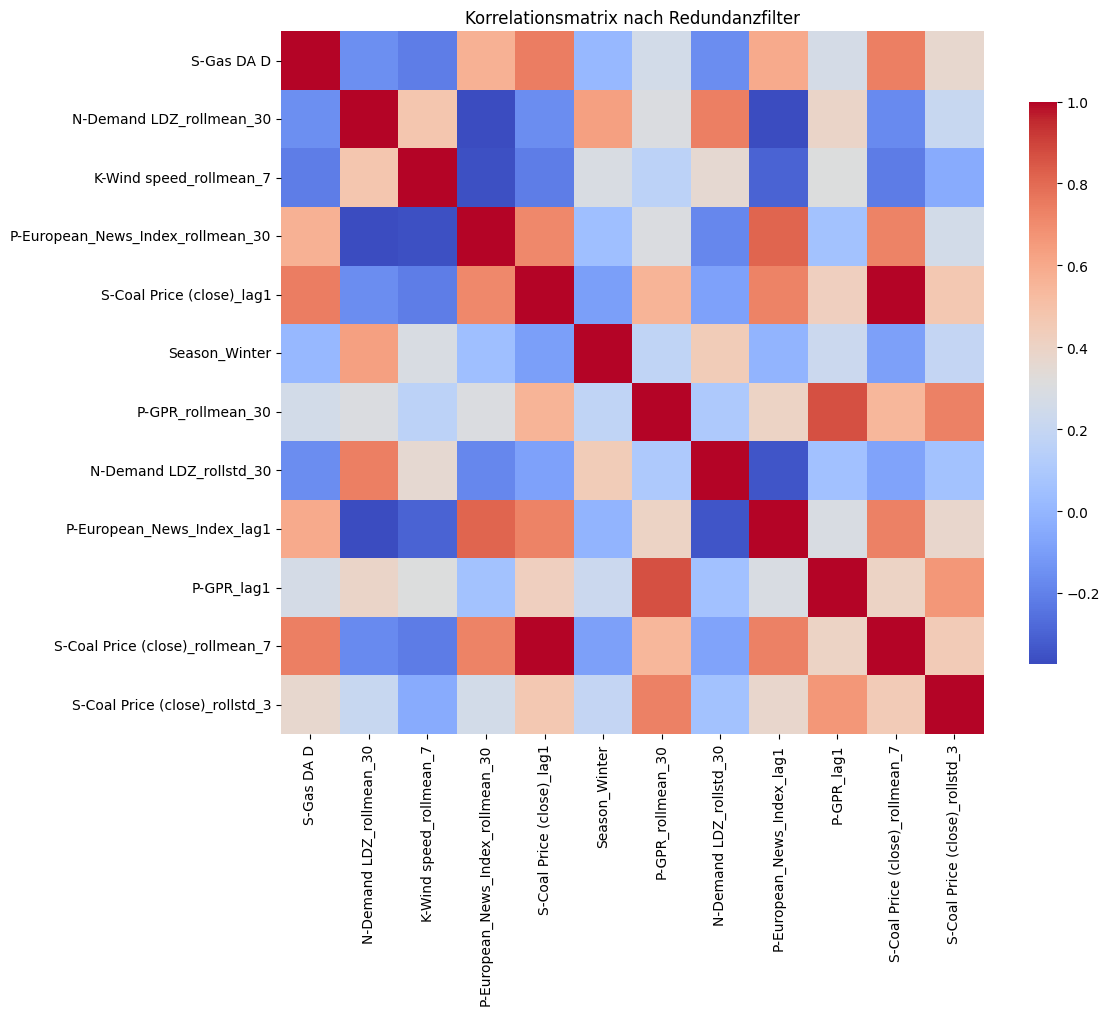

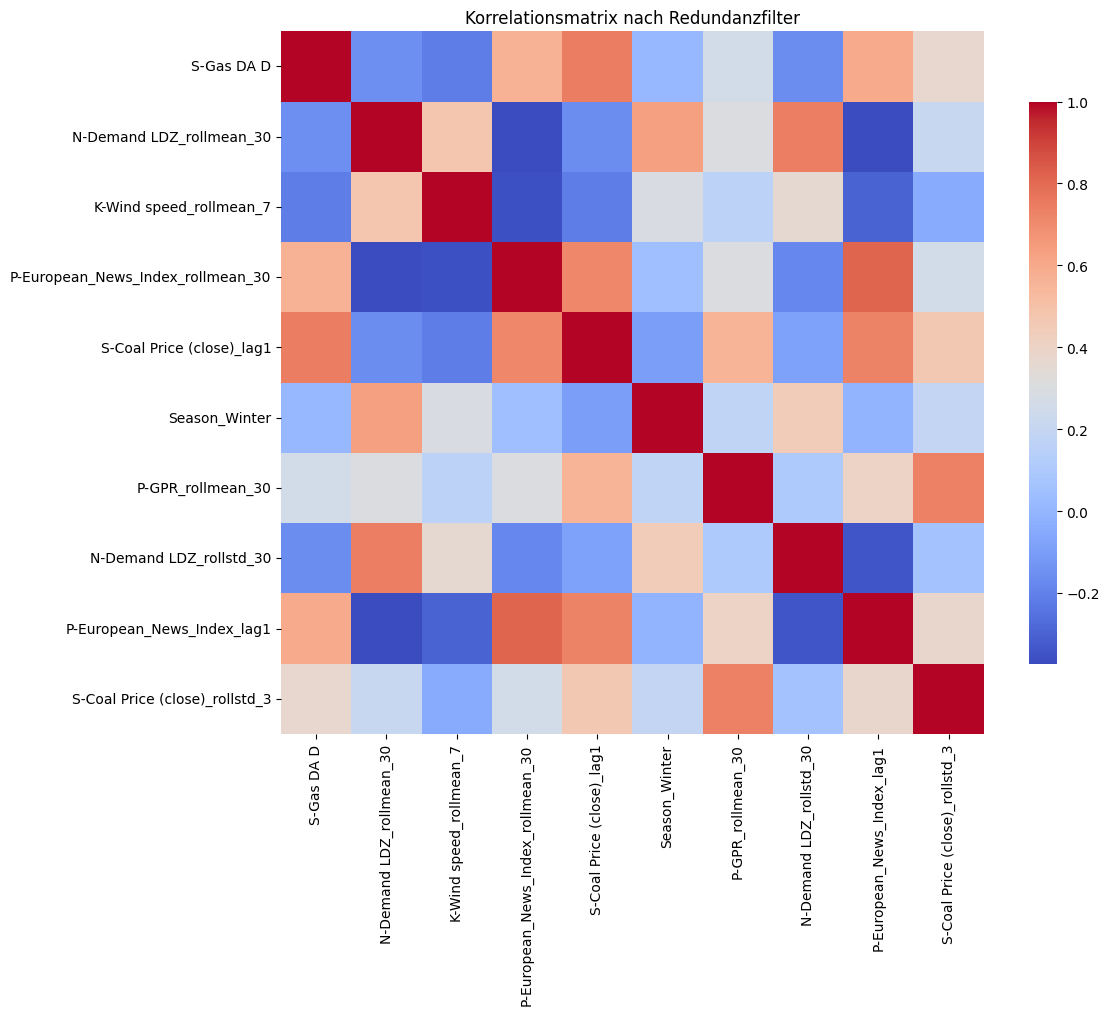

Gedroppte Features aufgrund hoher Korrelation:
- P-GPR_lag1
- S-Coal Price (close)_rollmean_7

Behaltene Features:
['S-Gas DA D', 'N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7', 'P-European_News_Index_rollmean_30', 'S-Coal Price (close)_lag1', 'Season_Winter', 'P-GPR_rollmean_30', 'N-Demand LDZ_rollstd_30', 'P-European_News_Index_lag1', 'S-Coal Price (close)_rollstd_3']


In [16]:
import seaborn as sns
X_selected = ['S-Gas DA D', 'N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7', 'P-European_News_Index_rollmean_30', 'S-Coal Price (close)_lag1', 'Season_Winter', 'P-GPR_rollmean_30', 'N-Demand LDZ_rollstd_30', 'P-European_News_Index_lag1', 'P-GPR_lag1', 'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_rollstd_3']
X_selected_df = train_df[X_selected]  # X_selected war die Liste der Spaltennamen

corr_selected = X_selected_df.corr().abs()
upper = corr_selected.where(np.triu(np.ones(corr_selected.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.85)]

plt.figure(figsize=(12, 10))
sns.heatmap(X_selected_df.corr(), annot=False, cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Korrelationsmatrix nach Redundanzfilter')
plt.tight_layout()
plt.show()
X_final = X_selected_df.drop(columns=to_drop)
plt.figure(figsize=(12, 10))
sns.heatmap(X_final.corr(), annot=False, cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Korrelationsmatrix nach Redundanzfilter')
plt.tight_layout()
plt.show()
# 7. Ausgegebene gedroppte Features
print("Gedroppte Features aufgrund hoher Korrelation:")
for feature in to_drop:
    print("-", feature)
selected_features = X_final.columns.tolist()

print("\nBehaltene Features:")
print("[" + ", ".join(f"'{f}'" for f in selected_features) + "]")


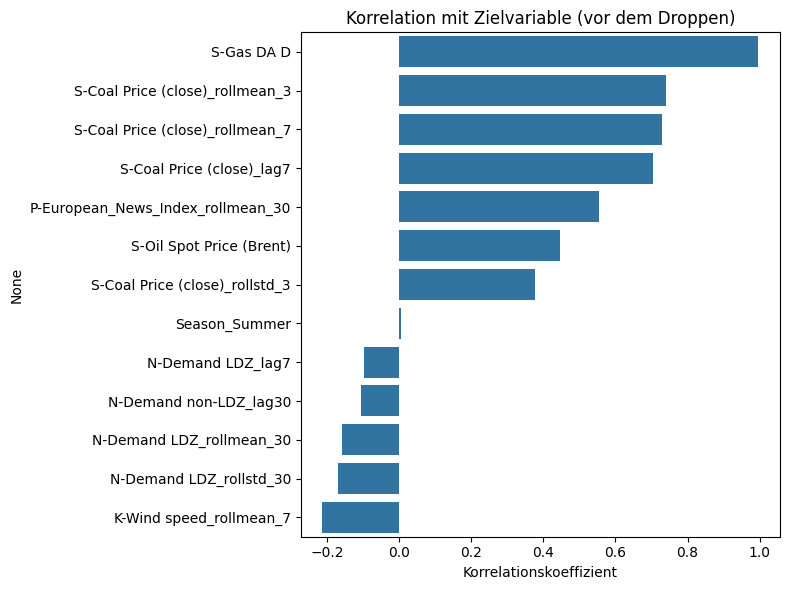

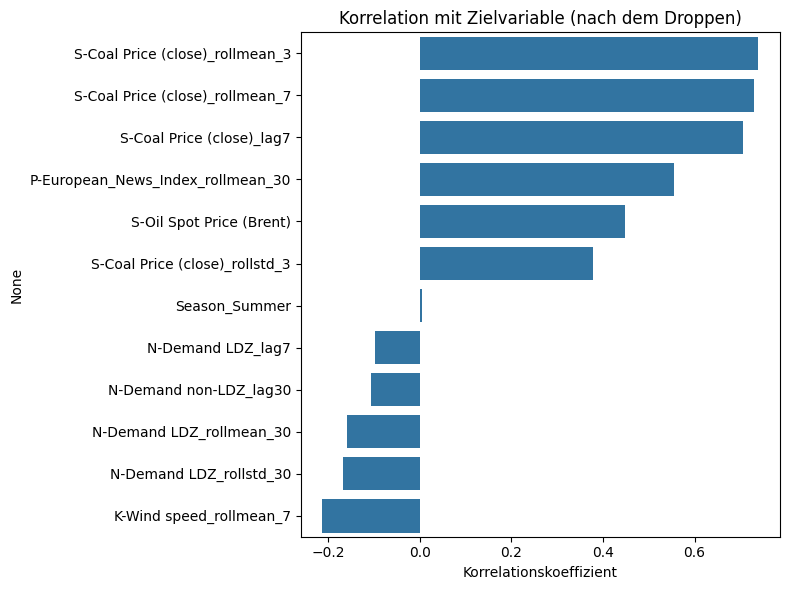

Verbleibende Features: ['S-Coal Price (close)_rollmean_3', 'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_lag7', 'P-European_News_Index_rollmean_30', 'S-Oil Spot Price (Brent)', 'S-Coal Price (close)_rollstd_3', 'Season_Summer', 'N-Demand LDZ_lag7', 'N-Demand non-LDZ_lag30', 'N-Demand LDZ_rollmean_30', 'N-Demand LDZ_rollstd_30', 'K-Wind speed_rollmean_7']


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Zielvariable anfügen
X_selected =  ['S-Gas DA D', 'N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7', 'P-European_News_Index_rollmean_30', 'S-Oil Spot Price (Brent)', 'S-Coal Price (close)_rollmean_3', 'N-Demand non-LDZ_lag30', 'Season_Summer', 'N-Demand LDZ_rollstd_30', 'S-Coal Price (close)_rollstd_3', 'N-Demand LDZ_lag7', 'S-Coal Price (close)_lag7', 'S-Coal Price (close)_rollmean_7']
corr_df = train_df[X_selected].copy()
corr_df['target'] = train_y_df.values

# Korrelation jedes Features mit dem Ziel
target_corr = corr_df.corr()['target'].drop('target').sort_values(ascending=False)

# Plot vor dem Dropping
plt.figure(figsize=(8, 6))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title('Korrelation mit Zielvariable (vor dem Droppen)')
plt.xlabel('Korrelationskoeffizient')
plt.tight_layout()
plt.show()

# Drop Features mit |Korrelation| > 0.9 zum Ziel
filtered_features = target_corr[abs(target_corr) <= 0.9].index.tolist()
X_test_filtered = train_df[filtered_features]

# Neue Korrelation berechnen
corr_df_filtered = X_test_filtered.copy()
corr_df_filtered['target'] = train_y_df.values
target_corr_filtered = corr_df_filtered.corr()['target'].drop('target').sort_values(ascending=False)

# Plot nach dem Droppen
plt.figure(figsize=(8, 6))
sns.barplot(x=target_corr_filtered.values, y=target_corr_filtered.index)
plt.title('Korrelation mit Zielvariable (nach dem Droppen)')
plt.xlabel('Korrelationskoeffizient')
plt.tight_layout()
plt.show()

# Final übrig gebliebene Features:
print("Verbleibende Features:", filtered_features)


### FS for EBM 

c:\Users\Lotta\OneDrive\Uni\Master\Masterarbeit Python 3.12\venvMasterarbeit\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.820e-03, tolerance: 2.031e-03
  model = cd_fast.enet_coordinate_descent(


Anzahl signifikanter Features (>|0.03|): 3
Ausgewählte Features: ['S-Gas DA D', 'S-Gas DA IT', 'S-Gas DA AU_rollmean_7']


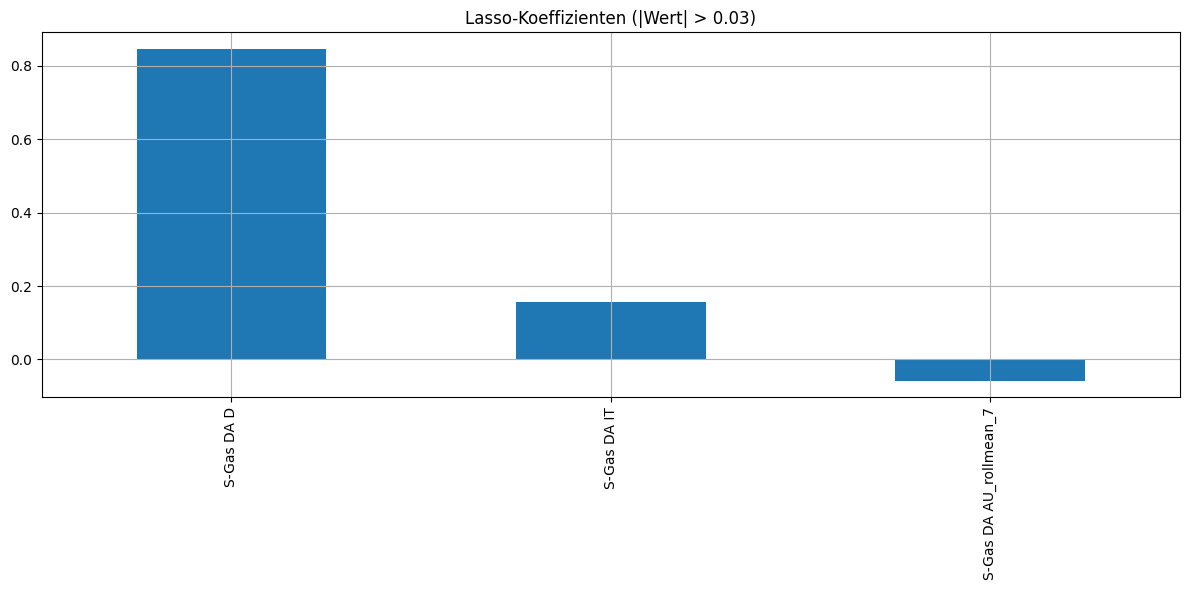

In [8]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Setup ---
X = train_df
y = train_y_df.values.ravel()

# --- 2. TimeSeriesSplit ---
tscv = TimeSeriesSplit(n_splits=3)

# --- 3. LassoCV mit Zeitreihen-CV ---
lasso = LassoCV(cv=tscv, random_state=42, n_jobs=-1)
lasso.fit(X, y)

# --- 4. Selektierte Features mit Schwellenwert ---
threshold = 0.03
coef_series = pd.Series(lasso.coef_, index=X.columns)
selected = coef_series[coef_series.abs() > threshold].sort_values(ascending=False)

print(f"Anzahl signifikanter Features (>|{threshold}|): {len(selected)}")
print("Ausgewählte Features:", selected.index.tolist())

# --- 5. Plot der signifikanten Koeffizienten ---
plt.figure(figsize=(12, 6))
selected.plot(kind="bar")
plt.xticks(rotation=90)
plt.title(f"Lasso-Koeffizienten (|Wert| > {threshold})")
plt.grid(True)
plt.tight_layout()
plt.show()
